In [4]:
%pip install pandas torch tqdm matplotlib imblearn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


In [6]:
df = pd.read_csv("../df_unbalanced_classification.csv")

selected_feature = [
    "differentiate",
    "Node Positive Ratio",
    "N Stage Encoded",
    "Estrogen Status Encoded",
    "Progesterone Status Encoded",
]

# X = df.drop(columns=["Survival More Than 6 Years"]).values
X = df[selected_feature].values
y = df["Status_encoded"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", X_train.shape, y_train.shape)
print("After SMOTE:", X_train_res.shape, y_train_res.shape)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Before SMOTE: (3219, 5) (3219,)
After SMOTE: (5446, 5) (5446,)


In [11]:
class SLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SLP, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = torch.softmax(logits, dim=1)
            return torch.argmax(probs, dim=1)

In [12]:
def train(model, train_loader, criterion, optimizer, epochs=50):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0

        for X_batch, y_batch in tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training"
        ):
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += (predicted == y_batch).sum().item()

        avg_train_loss = train_loss / len(train_dataset)
        avg_train_acc = train_acc / len(train_dataset)

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        model.eval()
        val_acc = 0
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(
                test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"
            ):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_acc += (predicted == y_batch).sum().item()

        avg_val_loss = val_loss / len(test_dataset)
        avg_val_acc = val_acc / len(test_dataset)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

        print(
            f"Epoch {epoch + 1}/{epochs} - "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}"
        )

    return train_losses, train_accuracies, val_losses, val_accuracies

In [13]:
model = SLP(input_dim=X_train_tensor.shape[1], output_dim=2)

criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 100

train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, criterion, optimizer, epochs=epochs
)

Epoch 1/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5349.62it/s]


Epoch 1/100 - Train Loss: 0.0248, Train Acc: 0.5108, Val Loss: 0.0217, Val Acc: 0.6807


Epoch 2/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5216.80it/s]


Epoch 2/100 - Train Loss: 0.0243, Train Acc: 0.5360, Val Loss: 0.0214, Val Acc: 0.6795


Epoch 3/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5164.91it/s]


Epoch 3/100 - Train Loss: 0.0237, Train Acc: 0.5487, Val Loss: 0.0211, Val Acc: 0.6807


Epoch 4/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5152.46it/s]


Epoch 4/100 - Train Loss: 0.0232, Train Acc: 0.5538, Val Loss: 0.0209, Val Acc: 0.6783


Epoch 5/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5143.47it/s]


Epoch 5/100 - Train Loss: 0.0229, Train Acc: 0.5637, Val Loss: 0.0207, Val Acc: 0.6845


Epoch 6/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5236.33it/s]


Epoch 6/100 - Train Loss: 0.0225, Train Acc: 0.5700, Val Loss: 0.0205, Val Acc: 0.6832


Epoch 7/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4924.23it/s]


Epoch 7/100 - Train Loss: 0.0222, Train Acc: 0.5758, Val Loss: 0.0203, Val Acc: 0.6832


Epoch 8/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4949.48it/s]


Epoch 8/100 - Train Loss: 0.0219, Train Acc: 0.5817, Val Loss: 0.0201, Val Acc: 0.6832


Epoch 9/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5376.25it/s]


Epoch 9/100 - Train Loss: 0.0216, Train Acc: 0.5867, Val Loss: 0.0200, Val Acc: 0.6807


Epoch 10/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5694.32it/s]


Epoch 10/100 - Train Loss: 0.0213, Train Acc: 0.5929, Val Loss: 0.0198, Val Acc: 0.6845


Epoch 11/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5396.47it/s]


Epoch 11/100 - Train Loss: 0.0211, Train Acc: 0.6004, Val Loss: 0.0197, Val Acc: 0.6857


Epoch 12/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5252.48it/s]


Epoch 12/100 - Train Loss: 0.0209, Train Acc: 0.6080, Val Loss: 0.0196, Val Acc: 0.6969


Epoch 13/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4949.71it/s]


Epoch 13/100 - Train Loss: 0.0207, Train Acc: 0.6116, Val Loss: 0.0195, Val Acc: 0.6981


Epoch 14/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5696.70it/s]


Epoch 14/100 - Train Loss: 0.0205, Train Acc: 0.6115, Val Loss: 0.0194, Val Acc: 0.7043


Epoch 15/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5717.91it/s]


Epoch 15/100 - Train Loss: 0.0204, Train Acc: 0.6127, Val Loss: 0.0193, Val Acc: 0.7130


Epoch 16/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4182.72it/s]


Epoch 16/100 - Train Loss: 0.0203, Train Acc: 0.6175, Val Loss: 0.0192, Val Acc: 0.7379


Epoch 17/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5088.04it/s]


Epoch 17/100 - Train Loss: 0.0202, Train Acc: 0.6272, Val Loss: 0.0192, Val Acc: 0.7503


Epoch 18/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5184.31it/s]


Epoch 18/100 - Train Loss: 0.0200, Train Acc: 0.6324, Val Loss: 0.0191, Val Acc: 0.7516


Epoch 19/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5551.98it/s]


Epoch 19/100 - Train Loss: 0.0200, Train Acc: 0.6474, Val Loss: 0.0191, Val Acc: 0.7478


Epoch 20/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5683.93it/s]


Epoch 20/100 - Train Loss: 0.0199, Train Acc: 0.6482, Val Loss: 0.0190, Val Acc: 0.7478


Epoch 21/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5321.16it/s]


Epoch 21/100 - Train Loss: 0.0198, Train Acc: 0.6480, Val Loss: 0.0190, Val Acc: 0.7478


Epoch 22/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5328.70it/s]


Epoch 22/100 - Train Loss: 0.0197, Train Acc: 0.6482, Val Loss: 0.0189, Val Acc: 0.7466


Epoch 23/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5216.55it/s]


Epoch 23/100 - Train Loss: 0.0197, Train Acc: 0.6485, Val Loss: 0.0189, Val Acc: 0.7466


Epoch 24/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 6094.67it/s]


Epoch 24/100 - Train Loss: 0.0196, Train Acc: 0.6485, Val Loss: 0.0189, Val Acc: 0.7466


Epoch 25/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5377.84it/s]


Epoch 25/100 - Train Loss: 0.0196, Train Acc: 0.6485, Val Loss: 0.0188, Val Acc: 0.7466


Epoch 26/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 4967.52it/s]


Epoch 26/100 - Train Loss: 0.0195, Train Acc: 0.6487, Val Loss: 0.0188, Val Acc: 0.7466


Epoch 27/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5937.06it/s]


Epoch 27/100 - Train Loss: 0.0196, Train Acc: 0.6487, Val Loss: 0.0188, Val Acc: 0.7466


Epoch 28/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5358.55it/s]


Epoch 28/100 - Train Loss: 0.0195, Train Acc: 0.6539, Val Loss: 0.0188, Val Acc: 0.7453


Epoch 29/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 6050.71it/s]


Epoch 29/100 - Train Loss: 0.0195, Train Acc: 0.6552, Val Loss: 0.0188, Val Acc: 0.7453


Epoch 30/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5398.61it/s]


Epoch 30/100 - Train Loss: 0.0195, Train Acc: 0.6552, Val Loss: 0.0188, Val Acc: 0.7453


Epoch 31/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 6231.89it/s]


Epoch 31/100 - Train Loss: 0.0194, Train Acc: 0.6557, Val Loss: 0.0188, Val Acc: 0.7416


Epoch 32/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5325.58it/s]


Epoch 32/100 - Train Loss: 0.0194, Train Acc: 0.6581, Val Loss: 0.0187, Val Acc: 0.7379


Epoch 33/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5377.31it/s]


Epoch 33/100 - Train Loss: 0.0194, Train Acc: 0.6586, Val Loss: 0.0187, Val Acc: 0.7429


Epoch 34/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5310.28it/s]


Epoch 34/100 - Train Loss: 0.0194, Train Acc: 0.6612, Val Loss: 0.0187, Val Acc: 0.7503


Epoch 35/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5540.41it/s]


Epoch 35/100 - Train Loss: 0.0194, Train Acc: 0.6634, Val Loss: 0.0187, Val Acc: 0.7528


Epoch 36/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5473.94it/s]


Epoch 36/100 - Train Loss: 0.0194, Train Acc: 0.6676, Val Loss: 0.0187, Val Acc: 0.7540


Epoch 37/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5039.83it/s]


Epoch 37/100 - Train Loss: 0.0194, Train Acc: 0.6684, Val Loss: 0.0187, Val Acc: 0.7491


Epoch 38/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5168.83it/s]


Epoch 38/100 - Train Loss: 0.0194, Train Acc: 0.6676, Val Loss: 0.0187, Val Acc: 0.7491


Epoch 39/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5254.75it/s]


Epoch 39/100 - Train Loss: 0.0193, Train Acc: 0.6658, Val Loss: 0.0187, Val Acc: 0.7491


Epoch 40/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5093.27it/s]


Epoch 40/100 - Train Loss: 0.0194, Train Acc: 0.6660, Val Loss: 0.0187, Val Acc: 0.7491


Epoch 41/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5465.44it/s]


Epoch 41/100 - Train Loss: 0.0193, Train Acc: 0.6647, Val Loss: 0.0187, Val Acc: 0.7478


Epoch 42/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5752.29it/s]


Epoch 42/100 - Train Loss: 0.0193, Train Acc: 0.6631, Val Loss: 0.0187, Val Acc: 0.7478


Epoch 43/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5631.39it/s]


Epoch 43/100 - Train Loss: 0.0193, Train Acc: 0.6631, Val Loss: 0.0187, Val Acc: 0.7478


Epoch 44/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5344.11it/s]


Epoch 44/100 - Train Loss: 0.0194, Train Acc: 0.6631, Val Loss: 0.0187, Val Acc: 0.7478


Epoch 45/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5619.20it/s]


Epoch 45/100 - Train Loss: 0.0193, Train Acc: 0.6631, Val Loss: 0.0187, Val Acc: 0.7478


Epoch 46/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5278.15it/s]


Epoch 46/100 - Train Loss: 0.0193, Train Acc: 0.6634, Val Loss: 0.0187, Val Acc: 0.7491


Epoch 47/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 6043.67it/s]


Epoch 47/100 - Train Loss: 0.0193, Train Acc: 0.6629, Val Loss: 0.0187, Val Acc: 0.7491


Epoch 48/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5069.35it/s]


Epoch 48/100 - Train Loss: 0.0193, Train Acc: 0.6610, Val Loss: 0.0187, Val Acc: 0.7491


Epoch 49/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5464.62it/s]


Epoch 49/100 - Train Loss: 0.0193, Train Acc: 0.6621, Val Loss: 0.0187, Val Acc: 0.7429


Epoch 50/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5393.00it/s]


Epoch 50/100 - Train Loss: 0.0193, Train Acc: 0.6616, Val Loss: 0.0187, Val Acc: 0.7429


Epoch 51/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5348.83it/s]


Epoch 51/100 - Train Loss: 0.0193, Train Acc: 0.6605, Val Loss: 0.0187, Val Acc: 0.7441


Epoch 52/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5301.76it/s]


Epoch 52/100 - Train Loss: 0.0193, Train Acc: 0.6603, Val Loss: 0.0187, Val Acc: 0.7441


Epoch 53/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5183.57it/s]


Epoch 53/100 - Train Loss: 0.0193, Train Acc: 0.6603, Val Loss: 0.0187, Val Acc: 0.7429


Epoch 54/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5172.26it/s]


Epoch 54/100 - Train Loss: 0.0193, Train Acc: 0.6607, Val Loss: 0.0187, Val Acc: 0.7441


Epoch 55/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5531.98it/s]


Epoch 55/100 - Train Loss: 0.0193, Train Acc: 0.6605, Val Loss: 0.0187, Val Acc: 0.7441


Epoch 56/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5206.34it/s]


Epoch 56/100 - Train Loss: 0.0193, Train Acc: 0.6605, Val Loss: 0.0187, Val Acc: 0.7441


Epoch 57/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5244.14it/s]


Epoch 57/100 - Train Loss: 0.0193, Train Acc: 0.6605, Val Loss: 0.0187, Val Acc: 0.7441


Epoch 58/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5096.84it/s]


Epoch 58/100 - Train Loss: 0.0193, Train Acc: 0.6605, Val Loss: 0.0187, Val Acc: 0.7441


Epoch 59/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5159.78it/s]


Epoch 59/100 - Train Loss: 0.0193, Train Acc: 0.6605, Val Loss: 0.0187, Val Acc: 0.7441


Epoch 60/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5127.99it/s]


Epoch 60/100 - Train Loss: 0.0192, Train Acc: 0.6601, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 61/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5851.99it/s]


Epoch 61/100 - Train Loss: 0.0193, Train Acc: 0.6601, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 62/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5456.41it/s]


Epoch 62/100 - Train Loss: 0.0193, Train Acc: 0.6601, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 63/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5132.10it/s]


Epoch 63/100 - Train Loss: 0.0192, Train Acc: 0.6601, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 64/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5297.38it/s]


Epoch 64/100 - Train Loss: 0.0193, Train Acc: 0.6601, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 65/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5803.72it/s]


Epoch 65/100 - Train Loss: 0.0192, Train Acc: 0.6601, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 66/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 6045.34it/s]


Epoch 66/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 67/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5356.45it/s]


Epoch 67/100 - Train Loss: 0.0192, Train Acc: 0.6601, Val Loss: 0.0188, Val Acc: 0.7429


Epoch 68/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 6299.94it/s]


Epoch 68/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0188, Val Acc: 0.7429


Epoch 69/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5600.73it/s]


Epoch 69/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0188, Val Acc: 0.7429


Epoch 70/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5558.20it/s]


Epoch 70/100 - Train Loss: 0.0193, Train Acc: 0.6601, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 71/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 6060.80it/s]


Epoch 71/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0188, Val Acc: 0.7429


Epoch 72/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5604.76it/s]


Epoch 72/100 - Train Loss: 0.0192, Train Acc: 0.6599, Val Loss: 0.0188, Val Acc: 0.7429


Epoch 73/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5141.53it/s]


Epoch 73/100 - Train Loss: 0.0193, Train Acc: 0.6596, Val Loss: 0.0188, Val Acc: 0.7429


Epoch 74/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5344.37it/s]


Epoch 74/100 - Train Loss: 0.0193, Train Acc: 0.6598, Val Loss: 0.0188, Val Acc: 0.7429


Epoch 75/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5186.53it/s]


Epoch 75/100 - Train Loss: 0.0193, Train Acc: 0.6598, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 76/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5262.11it/s]


Epoch 76/100 - Train Loss: 0.0192, Train Acc: 0.6598, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 77/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 6085.83it/s]


Epoch 77/100 - Train Loss: 0.0193, Train Acc: 0.6599, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 78/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5337.83it/s]


Epoch 78/100 - Train Loss: 0.0192, Train Acc: 0.6594, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 79/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5273.05it/s]


Epoch 79/100 - Train Loss: 0.0193, Train Acc: 0.6596, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 80/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5619.20it/s]


Epoch 80/100 - Train Loss: 0.0192, Train Acc: 0.6596, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 81/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5534.23it/s]


Epoch 81/100 - Train Loss: 0.0193, Train Acc: 0.6596, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 82/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5393.00it/s]


Epoch 82/100 - Train Loss: 0.0193, Train Acc: 0.6598, Val Loss: 0.0188, Val Acc: 0.7441


Epoch 83/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5721.81it/s]


Epoch 83/100 - Train Loss: 0.0193, Train Acc: 0.6586, Val Loss: 0.0188, Val Acc: 0.7317


Epoch 84/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5766.28it/s]


Epoch 84/100 - Train Loss: 0.0193, Train Acc: 0.6559, Val Loss: 0.0188, Val Acc: 0.7317


Epoch 85/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5637.51it/s]


Epoch 85/100 - Train Loss: 0.0192, Train Acc: 0.6553, Val Loss: 0.0188, Val Acc: 0.7317


Epoch 86/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5221.04it/s]


Epoch 86/100 - Train Loss: 0.0192, Train Acc: 0.6553, Val Loss: 0.0188, Val Acc: 0.7317


Epoch 87/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5519.94it/s]


Epoch 87/100 - Train Loss: 0.0193, Train Acc: 0.6552, Val Loss: 0.0188, Val Acc: 0.7317


Epoch 88/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5578.10it/s]


Epoch 88/100 - Train Loss: 0.0193, Train Acc: 0.6544, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 89/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5600.73it/s]


Epoch 89/100 - Train Loss: 0.0193, Train Acc: 0.6542, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 90/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5602.17it/s]


Epoch 90/100 - Train Loss: 0.0192, Train Acc: 0.6535, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 91/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5566.43it/s]


Epoch 91/100 - Train Loss: 0.0192, Train Acc: 0.6533, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 92/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5402.89it/s]


Epoch 92/100 - Train Loss: 0.0193, Train Acc: 0.6535, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 93/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5912.27it/s]


Epoch 93/100 - Train Loss: 0.0192, Train Acc: 0.6537, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 94/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5234.58it/s]


Epoch 94/100 - Train Loss: 0.0193, Train Acc: 0.6535, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 95/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5413.35it/s]


Epoch 95/100 - Train Loss: 0.0193, Train Acc: 0.6541, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 96/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5443.88it/s]


Epoch 96/100 - Train Loss: 0.0192, Train Acc: 0.6542, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 97/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5965.97it/s]


Epoch 97/100 - Train Loss: 0.0192, Train Acc: 0.6541, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 98/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5767.50it/s]


Epoch 98/100 - Train Loss: 0.0193, Train Acc: 0.6539, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 99/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5191.71it/s]


Epoch 99/100 - Train Loss: 0.0192, Train Acc: 0.6541, Val Loss: 0.0188, Val Acc: 0.7304


Epoch 100/100 - Validation: 100%|██████████| 26/26 [00:00<00:00, 5342.02it/s]

Epoch 100/100 - Train Loss: 0.0192, Train Acc: 0.6539, Val Loss: 0.0188, Val Acc: 0.7304


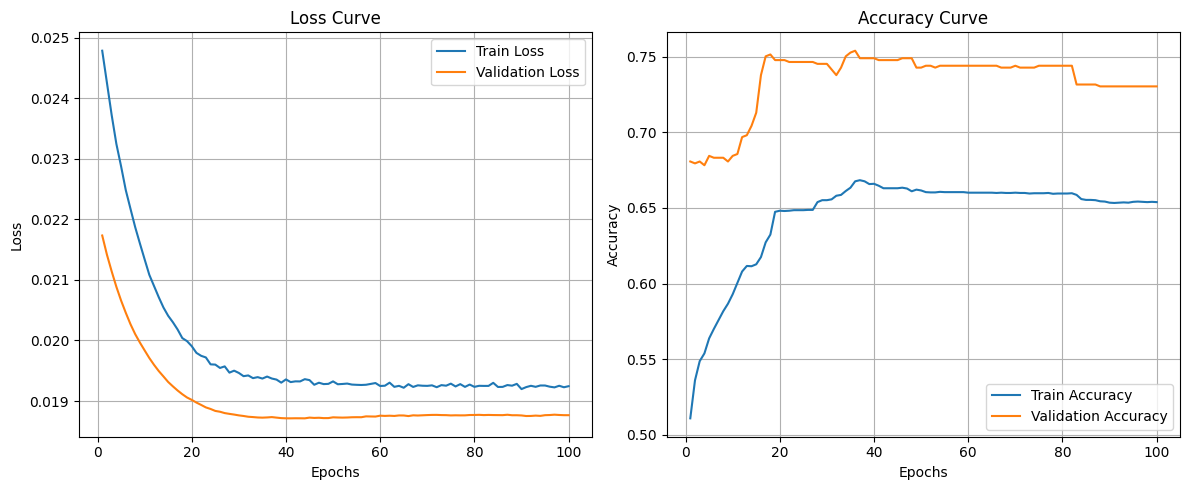

In [14]:
epochs_range = list(range(1, epochs + 1))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
axs[0].plot(epochs_range, train_losses, label="Train Loss")
axs[0].plot(epochs_range, val_losses, label="Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss Curve")
axs[0].legend()
axs[0].grid(True)

# Plot Accuracy
axs[1].plot(epochs_range, train_accuracies, label="Train Accuracy")
axs[1].plot(epochs_range, val_accuracies, label="Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy Curve")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


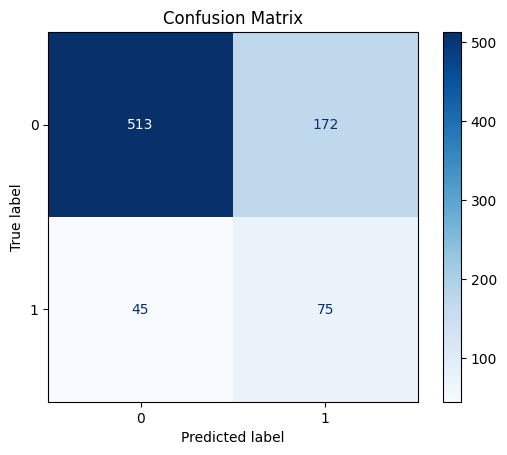

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_tensor)
y_true = y_test_tensor.cpu().numpy()
y_pred = y_pred.cpu().numpy()

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()